Main LOO Cross Validation

Load Packages

In [1]:
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture
from StableRdmDataset import StableRdmDataset
import h5py
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from matplotlib import animation
import torch
import torch.nn as nn
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import optim
from datetime import datetime
from RdmSingleVariablePrediction import RdmCNNLSTMModel
from sklearn.model_selection import KFold
from scipy import stats
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Load Events Dataframe

In [2]:
event_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

event_labels_df = pd.read_csv(event_csv_path)
print(event_labels_df.head())

    RADAR_capture  MOCAP_Start_Time  MOCAP_End_Time  RADAR_Start_Frame  \
0  01_MNTRL_RR_V1              7.33           30.57                194   
1  01_MNTRL_RR_V1              7.33           30.57                194   
2  01_MNTRL_RR_V1              7.33           30.57                194   
3  01_MNTRL_RR_V2              7.37           30.40                191   
4  01_MNTRL_RR_V2              7.37           30.40                191   

   RADAR_End_Frame  Seconds_per_Frame  tx  is_final_tx  t_foot_up  t_stable  \
0              831            0.03645   1        False      10.22     11.19   
1              831            0.03645   2        False      18.25     19.05   
2              831            0.03645   3         True      26.24     27.03   
3              822            0.03646   1        False      10.48     11.05   
4              822            0.03646   2        False      18.41     19.07   

   t_break  t_foot_down  frame_foot_up  frame_stable  frame_break  frame_end  
0

Training and Testing Functions

In [3]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    """
    Train a model on a given dataset.

    Parameters:
    - model: The neural network model to be trained.
    - dataloader: DataLoader for the training data.
    - criterion: The loss function.
    - optimizer: The optimization algorithm.
    - num_epochs: The number of epochs to train for.
    - device: The device (CPU or GPU) to train on.

    Returns:
    - model: The trained model.
    """

    # Move model to the specified device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate over data
        for inputs, velocities, _, _ in dataloader:
            inputs = inputs.to(device)
            velocities = velocities.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, velocities)

            # Backward pass + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Train Loss: {epoch_loss:.4f}\n')

    print('Training complete')
    return model


def train_validate_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    
    best_val_loss = float('inf')

    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for inputs, velocities, _, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                velocities = velocities.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, velocities)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

                # Track the best performance
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                print(f"New best validation loss is: {best_val_loss}")
        
        print()

    print('Training complete')

    return model, best_val_loss

def test_model(model, dataloader, device=torch.device("cpu")):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    criterion = nn.MSELoss()  # Example criterion, adjust as necessary

    # No gradient updates
    with torch.no_grad():
        for inputs, velocities, _, _ in dataloader:
            inputs = inputs.to(device)
            velocities = velocities.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, velocities)

            # Statistics
            running_loss += loss.item() * inputs.size(0)

    total_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {total_loss:.4f}')


LOO Cross Validation

In [ ]:

# Define the root directory and event CSV file path
root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch'
event_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

# Get all folders and shuffle them randomly
all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
random.seed(42)
random.shuffle(all_folders)

# Define the setup_loaders function
def setup_loaders(root_dir, event_csv, folders):
    datasets = {x: StableRdmDataset(root_dir, event_csv, folders[x], label_type="avg_speed") for x in ['train', 'test']}
    loaders = {x: DataLoader(datasets[x], batch_size=2, shuffle=True if x == 'train' else False, collate_fn=StableRdmDataset.collate_fn) for x in datasets}
    return loaders

# Model saving directory
model_save_dir = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/LOO_CV_models_v2"

# Implement Leave-One-Out Cross-Validation
for i, test_folder in enumerate(all_folders):
    print(f"Starting LOO with {test_folder} as test set")
    
    # Split folders into training and test sets
    train_folders = [f for f in all_folders if f != test_folder]
    folders = {'train': train_folders, 'test': [test_folder]}
    
    # Create the DataLoaders
    loaders = setup_loaders(root_dir, event_csv, folders)
    train_loader, test_loader = loaders['train'], loaders['test']
    
    # Initialize the model
    model = RdmCNNLSTMModel(num_channels=1, hidden_dim=128, lstm_layers=2, bidirectional=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Train the model on this fold's training data
    model = train_model(model, train_loader, criterion, optimizer, num_epochs=5, device=device)
    
    # Update model save path to include the test folder name
    model_save_path = os.path.join(model_save_dir, f'model_LOO_{test_folder}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Evaluation logic for each test folder as needed
    # Your evaluation logic here...

print("Leave-One-Out Cross-Validation complete.")

Fine Tune Models

In [4]:
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from collections import defaultdict
import matplotlib.pyplot as plt


# Define the setup_loaders function
def setup_test_loaders(root_dir, event_csv, folders):
    datasets = {x: StableRdmDataset(root_dir, event_csv, folders[x], label_type="avg_speed") for x in ['test']}
    loaders = {x: DataLoader(datasets[x], batch_size=2, shuffle=True if x == 'train' else False, collate_fn=StableRdmDataset.collate_fn) for x in datasets}
    return loaders


def load_model(model_path, device):
    """Load a pre-trained model."""
    model = RdmCNNLSTMModel(num_channels=1, hidden_dim=128, lstm_layers=2, bidirectional=False) # Instantiate your model class
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

def prepare_data_for_participant(test_loader, fraction_fine_tune, FRACTION_EVAL, seed=42):
    total_size = len(test_loader.dataset)
    eval_size = int(total_size * FRACTION_EVAL)  # FRACTION_EVAL * 100% the data for evaluation
    fine_tune_available_size = total_size - eval_size  # The other 50% for potential fine-tuning
    
    # Determine fine-tuning size based on the specified fraction
    fine_tune_size = int(fine_tune_available_size * fraction_fine_tune)
    
    # Consistently use the latter half of the dataset for evaluation
    eval_indices = list(range(eval_size, total_size))
    eval_subset = Subset(test_loader.dataset, indices=eval_indices)
    eval_loader = DataLoader(eval_subset, batch_size=2, shuffle=False, collate_fn=test_loader.collate_fn)
    
    if fine_tune_size == 0:
        return None, eval_loader

    # Use the beginning portion up to fine_tune_size for fine-tuning
    fine_tune_indices = list(range(0, fine_tune_size))
    fine_tune_subset = Subset(test_loader.dataset, indices=fine_tune_indices)
    fine_tune_loader = DataLoader(fine_tune_subset, batch_size=2, shuffle=True, collate_fn=test_loader.collate_fn)
    

    return fine_tune_loader, eval_loader


def fine_tune_model(model, fine_tune_loader, device, epochs=2):
    """Fine-tunes the model on a subset of data."""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    criterion = nn.MSELoss()  # Or your specific loss function
    for epoch in range(epochs):
        for inputs, labels, length, metadata in fine_tune_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, actuals, participants = [], [], []
    with torch.no_grad():
        for inputs, labels, _, metadata in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).cpu().numpy())
            actuals.extend(labels.view(-1).cpu().numpy())

            # Extract participant_id from each metadata dictionary in the list
            for meta in metadata:
                participants.append(meta['participant_id'])
    
    return predictions, actuals, participants


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models_dir = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/LOO_CV_models"
    root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch'
    event_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"
    
    # Automatically load model paths
    model_paths = [os.path.join(models_dir, f) for f in os.listdir(models_dir) if f.startswith('model_LOO_') and f.endswith('.pth')]
    
    # Get all folders and shuffle them randomly for reproducibility if needed
    all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    random.seed(42)
    random.shuffle(all_folders)
    
    r2_scores = []
    mse_scores = []
    all_results = defaultdict(list)
    
    for model_path in model_paths:
        model_name = os.path.basename(model_path)
        test_folder = model_name.replace('model_LOO_', '').replace('.pth', '')
        print(f"Evaluating {model_name} with {test_folder} as the test set")

        # Ensure the test folder is one of the available folders, skip otherwise
        if test_folder not in all_folders:
            print(f"Test folder {test_folder} not found in the dataset. Skipping...")
            continue

        
        folders = {'test': [test_folder]}
        loaders = setup_test_loaders(root_dir, event_csv, folders)
        test_loader = loaders['test']

        FRACTION_EVAL = 0.75
        for fraction_fine_tune in np.linspace(0, 1.0, 10):
            # Load the fresh model
            model = load_model(model_path, device)
            
            # Prep the fine tune and eval loaders
            fine_tune_loader, eval_loader = prepare_data_for_participant(test_loader, fraction_fine_tune, FRACTION_EVAL, seed=42)
            
            # Fine tune, but skip first round of fine tuning
            if fine_tune_loader is not None:
                fine_tune_model(model, fine_tune_loader, device)
                
            preds, actuals, participants = evaluate_model(model, eval_loader, device)
            all_results[fraction_fine_tune].append({
                'predictions': preds,
                'actuals': actuals,
                'participants': participants
            })
    return all_results

# Execute main function and unpack returned scores
if __name__ == "__main__":
    all_results = main()


Evaluating model_LOO_24.pth with 24 as the test set
The shape of the 24_MNTRL_RR_V1, tx 1 is: (100, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 3 is: (109, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 2 is: (92, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 3 is: (87, 23, 13)
The shape of the 24_MNTRL_RR_V3, tx 1 is: (93, 23, 13)
The shape of the 24_MNTRL_RR_V3, tx 2 is: (85, 23, 13)
The shape of the 24_MNTRL_RR_V3, tx 3 is: (98, 23, 13)
The shape of the 24_MNTRR_RR_V1, tx 1 is: (45, 23, 13)
The shape of the 24_MNTRR_RR_V1, tx 3 is: (103, 23, 13)
The shape of the 24_MNTRR_RR_V1, tx 4 is: (109, 23, 13)
The shape of the 24_MNTRR_RR_V2, tx 1 is: (89, 23, 13)
The shape of the 24_MNTRR_RR_V2, tx 2 is: (91, 23, 13)
The shape of the 24_MNTRR_RR_V2, tx 3 is: (104, 23, 13)
The shape of the 24_MNTRR_RR_V3, tx 1 is: (99, 23, 13)
The shape of the 24_MNTRR_RR_V3, tx 2 is: (97, 23, 13)
The sha

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_18.pth with 18 as the test set
The shape of the 18_MNTRL_RR_V1, tx 1 is: (86, 23, 13)
The shape of the 18_MNTRL_RR_V1, tx 2 is: (92, 23, 13)
The shape of the 18_MNTRL_RR_V1, tx 3 is: (110, 23, 13)
The shape of the 18_MNTRL_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 18_MNTRL_RR_V2, tx 2 is: (87, 23, 13)
The shape of the 18_MNTRL_RR_V2, tx 3 is: (84, 23, 13)
The shape of the 18_MNTRL_RR_V3, tx 1 is: (84, 23, 13)
The shape of the 18_MNTRL_RR_V3, tx 2 is: (89, 23, 13)
The shape of the 18_MNTRL_RR_V3, tx 3 is: (90, 23, 13)
The shape of the 18_MNTRR_RR_V1, tx 1 is: (99, 23, 13)
The shape of the 18_MNTRR_RR_V1, tx 2 is: (94, 23, 13)
The shape of the 18_MNTRR_RR_V1, tx 3 is: (73, 23, 13)
The shape of the 18_MNTRR_RR_V2, tx 1 is: (101, 23, 13)
The shape of the 18_MNTRR_RR_V2, tx 2 is: (93, 23, 13)
The shape of the 18_MNTRR_RR_V2, tx 3 is: (107, 23, 13)
The shape of the 18_MNTRR_RR_V3, tx 1 is: (81, 23, 13)
The shape of the 18_MNTRR_RR_V3, tx 2 is: (106, 23, 13)
The shape

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_22.pth with 22 as the test set
The shape of the 22_MNTRL_RR_V1, tx 1 is: (32, 23, 13)
The shape of the 22_MNTRL_RR_V1, tx 2 is: (96, 23, 13)
The shape of the 22_MNTRL_RR_V2, tx 1 is: (92, 23, 13)
The shape of the 22_MNTRL_RR_V2, tx 2 is: (94, 23, 13)
The shape of the 22_MNTRL_RR_V2, tx 3 is: (99, 23, 13)
The shape of the 22_MNTRL_RR_V3, tx 1 is: (87, 23, 13)
The shape of the 22_MNTRL_RR_V3, tx 2 is: (87, 23, 13)
The shape of the 22_MNTRL_RR_V3, tx 3 is: (99, 23, 13)
The shape of the 22_MNTRR_RR_V1, tx 1 is: (54, 23, 13)
The shape of the 22_MNTRR_RR_V1, tx 2 is: (92, 23, 13)
The shape of the 22_MNTRR_RR_V1, tx 3 is: (95, 23, 13)
The shape of the 22_MNTRR_RR_V2, tx 1 is: (84, 23, 13)
The shape of the 22_MNTRR_RR_V2, tx 2 is: (84, 23, 13)
The shape of the 22_MNTRR_RR_V2, tx 3 is: (123, 23, 13)
The shape of the 22_MNTRR_RR_V3, tx 1 is: (82, 23, 13)
The shape of the 22_MNTRR_RR_V3, tx 2 is: (92, 23, 13)
The shape of the 22_MNTRR_RR_V3, tx 3 is: (108, 23, 13)


/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_08.pth with 08 as the test set
The shape of the 08_MNTRL_RR_V1, tx 1 is: (96, 23, 13)
The shape of the 08_MNTRL_RR_V1, tx 2 is: (98, 23, 13)
The shape of the 08_MNTRL_RR_V1, tx 3 is: (106, 23, 13)
The shape of the 08_MNTRL_RR_V2, tx 1 is: (84, 23, 13)
The shape of the 08_MNTRL_RR_V2, tx 2 is: (97, 23, 13)
The shape of the 08_MNTRL_RR_V2, tx 3 is: (107, 23, 13)
The shape of the 08_MNTRL_RR_V3, tx 1 is: (94, 23, 13)
The shape of the 08_MNTRL_RR_V3, tx 2 is: (103, 23, 13)
The shape of the 08_MNTRL_RR_V3, tx 3 is: (95, 23, 13)
The shape of the 08_MNTRR_RR_V1, tx 1 is: (52, 23, 13)
The shape of the 08_MNTRR_RR_V1, tx 2 is: (98, 23, 13)
The shape of the 08_MNTRR_RR_V1, tx 3 is: (103, 23, 13)
The shape of the 08_MNTRR_RR_V2, tx 1 is: (88, 23, 13)
The shape of the 08_MNTRR_RR_V2, tx 2 is: (92, 23, 13)
The shape of the 08_MNTRR_RR_V2, tx 3 is: (106, 23, 13)
The shape of the 08_MNTRR_RR_V3, tx 1 is: (85, 23, 13)
The shape of the 08_MNTRR_RR_V3, tx 2 is: (95, 23, 13)
The shap

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_10.pth with 10 as the test set
The shape of the 10_MNTRL_RR_V1, tx 1 is: (103, 23, 13)
The shape of the 10_MNTRL_RR_V1, tx 2 is: (83, 23, 13)
The shape of the 10_MNTRL_RR_V1, tx 3 is: (94, 23, 13)
The shape of the 10_MNTRL_RR_V2, tx 1 is: (103, 23, 13)
The shape of the 10_MNTRL_RR_V2, tx 2 is: (100, 23, 13)
The shape of the 10_MNTRL_RR_V2, tx 3 is: (65, 23, 13)
The shape of the 10_MNTRL_RR_V3, tx 1 is: (97, 23, 13)
The shape of the 10_MNTRL_RR_V3, tx 2 is: (100, 23, 13)
The shape of the 10_MNTRL_RR_V3, tx 3 is: (88, 23, 13)
The shape of the 10_MNTRR_RR_V1, tx 1 is: (90, 23, 13)
The shape of the 10_MNTRR_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 10_MNTRR_RR_V1, tx 3 is: (100, 23, 13)
The shape of the 10_MNTRR_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 10_MNTRR_RR_V2, tx 2 is: (88, 23, 13)
The shape of the 10_MNTRR_RR_V2, tx 3 is: (95, 23, 13)
The shape of the 10_MNTRR_RR_V3, tx 1 is: (101, 23, 13)
The shape of the 10_MNTRR_RR_V3, tx 2 is: (97, 23, 13)
The sh

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_04.pth with 04 as the test set
The shape of the 04_MNTRL_RR_V1, tx 1 is: (88, 23, 13)
The shape of the 04_MNTRL_RR_V1, tx 2 is: (96, 23, 13)
The shape of the 04_MNTRL_RR_V1, tx 3 is: (97, 23, 13)
The shape of the 04_MNTRL_RR_V2, tx 1 is: (91, 23, 13)
The shape of the 04_MNTRL_RR_V2, tx 2 is: (66, 23, 13)
The shape of the 04_MNTRL_RR_V2, tx 3 is: (77, 23, 13)
The shape of the 04_MNTRL_RR_V3, tx 1 is: (92, 23, 13)
The shape of the 04_MNTRL_RR_V3, tx 2 is: (91, 23, 13)
The shape of the 04_MNTRL_RR_V3, tx 3 is: (91, 23, 13)
The shape of the 04_MNTRR_RR_V1, tx 1 is: (86, 23, 13)
The shape of the 04_MNTRR_RR_V1, tx 2 is: (91, 23, 13)
The shape of the 04_MNTRR_RR_V1, tx 3 is: (93, 23, 13)
The shape of the 04_MNTRR_RR_V2, tx 1 is: (86, 23, 13)
The shape of the 04_MNTRR_RR_V2, tx 2 is: (81, 23, 13)
The shape of the 04_MNTRR_RR_V2, tx 3 is: (95, 23, 13)
The shape of the 04_MNTRR_RR_V3, tx 1 is: (95, 23, 13)
The shape of the 04_MNTRR_RR_V3, tx 2 is: (98, 23, 13)
The shape of 

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_05.pth with 05 as the test set
The shape of the 05_MNTRL_RR_V1, tx 1 is: (101, 23, 13)
The shape of the 05_MNTRL_RR_V1, tx 2 is: (89, 23, 13)
The shape of the 05_MNTRL_RR_V1, tx 3 is: (108, 23, 13)
The shape of the 05_MNTRL_RR_V2, tx 1 is: (104, 23, 13)
The shape of the 05_MNTRL_RR_V2, tx 2 is: (95, 23, 13)
The shape of the 05_MNTRL_RR_V2, tx 3 is: (104, 23, 13)
The shape of the 05_MNTRL_RR_V3, tx 1 is: (97, 23, 13)
The shape of the 05_MNTRL_RR_V3, tx 2 is: (97, 23, 13)
The shape of the 05_MNTRL_RR_V3, tx 3 is: (104, 23, 13)
The shape of the 05_MNTRR_RR_V1, tx 1 is: (99, 23, 13)
The shape of the 05_MNTRR_RR_V1, tx 2 is: (100, 23, 13)
The shape of the 05_MNTRR_RR_V1, tx 3 is: (105, 23, 13)
The shape of the 05_MNTRR_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 05_MNTRR_RR_V2, tx 2 is: (99, 23, 13)
The shape of the 05_MNTRR_RR_V2, tx 3 is: (105, 23, 13)
The shape of the 05_MNTRR_RR_V3, tx 1 is: (97, 23, 13)
The shape of the 05_MNTRR_RR_V3, tx 2 is: (96, 23, 13)
The s

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_13.pth with 13 as the test set
The shape of the 13_MNTRL_RR_V1, tx 1 is: (27, 23, 13)
The shape of the 13_MNTRL_RR_V1, tx 2 is: (35, 23, 13)
The shape of the 13_MNTRL_RR_V1, tx 3 is: (94, 23, 13)
The shape of the 13_MNTRL_RR_V1, tx 4 is: (51, 23, 13)
The shape of the 13_MNTRL_RR_V1, tx 5 is: (39, 23, 13)
The shape of the 13_MNTRL_RR_V2, tx 1 is: (84, 23, 13)
The shape of the 13_MNTRL_RR_V2, tx 2 is: (88, 23, 13)
The shape of the 13_MNTRL_RR_V2, tx 3 is: (95, 23, 13)
The shape of the 13_MNTRL_RR_V3, tx 1 is: (85, 23, 13)
The shape of the 13_MNTRL_RR_V3, tx 2 is: (92, 23, 13)
The shape of the 13_MNTRL_RR_V3, tx 3 is: (85, 23, 13)
The shape of the 13_MNTRR_RR_V1, tx 1 is: (91, 23, 13)
The shape of the 13_MNTRR_RR_V1, tx 2 is: (90, 23, 13)
The shape of the 13_MNTRR_RR_V1, tx 3 is: (84, 23, 13)
The shape of the 13_MNTRR_RR_V2, tx 1 is: (93, 23, 13)
The shape of the 13_MNTRR_RR_V2, tx 2 is: (94, 23, 13)
The shape of the 13_MNTRR_RR_V2, tx 3 is: (95, 23, 13)
The shape of 

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_12.pth with 12 as the test set
The shape of the 12_MNTRL_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 12_MNTRL_RR_V2, tx 2 is: (96, 23, 13)
The shape of the 12_MNTRL_RR_V2, tx 3 is: (101, 23, 13)
The shape of the 12_MNTRL_RR_V3, tx 1 is: (95, 23, 13)
The shape of the 12_MNTRL_RR_V3, tx 2 is: (101, 23, 13)
The shape of the 12_MNTRL_RR_V3, tx 3 is: (97, 23, 13)
The shape of the 12_MNTRR_RR_V1, tx 2 is: (62, 23, 13)
The shape of the 12_MNTRR_RR_V1, tx 3 is: (97, 23, 13)
The shape of the 12_MNTRR_RR_V1, tx 4 is: (105, 23, 13)
The shape of the 12_MNTRR_RR_V2, tx 1 is: (95, 23, 13)
The shape of the 12_MNTRR_RR_V2, tx 2 is: (92, 23, 13)
The shape of the 12_MNTRR_RR_V2, tx 3 is: (99, 23, 13)
The shape of the 12_MNTRR_RR_V3, tx 1 is: (89, 23, 13)
The shape of the 12_MNTRR_RR_V3, tx 2 is: (92, 23, 13)
The shape of the 12_MNTRR_RR_V3, tx 3 is: (100, 23, 13)


/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_02.pth with 02 as the test set
The shape of the 02_MNTRL_RR_V1, tx 1 is: (91, 23, 13)
The shape of the 02_MNTRL_RR_V1, tx 2 is: (93, 23, 13)
The shape of the 02_MNTRL_RR_V1, tx 3 is: (68, 23, 13)
The shape of the 02_MNTRL_RR_V2, tx 1 is: (103, 23, 13)
The shape of the 02_MNTRL_RR_V2, tx 2 is: (85, 23, 13)
The shape of the 02_MNTRL_RR_V2, tx 3 is: (76, 23, 13)
The shape of the 02_MNTRL_RR_V3, tx 1 is: (87, 23, 13)
The shape of the 02_MNTRL_RR_V3, tx 2 is: (93, 23, 13)
The shape of the 02_MNTRL_RR_V3, tx 3 is: (72, 23, 13)
The shape of the 02_MNTRR_RR_V1, tx 1 is: (82, 23, 13)
The shape of the 02_MNTRR_RR_V1, tx 2 is: (85, 23, 13)
The shape of the 02_MNTRR_RR_V1, tx 3 is: (80, 23, 13)
The shape of the 02_MNTRR_RR_V2, tx 1 is: (93, 23, 13)
The shape of the 02_MNTRR_RR_V2, tx 2 is: (87, 23, 13)
The shape of the 02_MNTRR_RR_V2, tx 3 is: (85, 23, 13)
The shape of the 02_MNTRR_RR_V3, tx 1 is: (82, 23, 13)
The shape of the 02_MNTRR_RR_V3, tx 2 is: (97, 23, 13)
The shape of

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_16.pth with 16 as the test set
The shape of the 16_MNTRL_RR_V1, tx 1 is: (102, 23, 13)
The shape of the 16_MNTRL_RR_V1, tx 2 is: (80, 23, 13)
The shape of the 16_MNTRL_RR_V1, tx 3 is: (20, 23, 13)
The shape of the 16_MNTRL_RR_V1, tx 4 is: (60, 23, 13)
The shape of the 16_MNTRL_RR_V2, tx 1 is: (87, 23, 13)
The shape of the 16_MNTRL_RR_V2, tx 2 is: (93, 23, 13)
The shape of the 16_MNTRL_RR_V2, tx 3 is: (105, 23, 13)
The shape of the 16_MNTRL_RR_V3, tx 1 is: (91, 23, 13)
The shape of the 16_MNTRL_RR_V3, tx 2 is: (91, 23, 13)
The shape of the 16_MNTRL_RR_V3, tx 3 is: (107, 23, 13)
The shape of the 16_MNTRR_RR_V1, tx 1 is: (85, 23, 13)
The shape of the 16_MNTRR_RR_V1, tx 2 is: (92, 23, 13)
The shape of the 16_MNTRR_RR_V1, tx 3 is: (89, 23, 13)
The shape of the 16_MNTRR_RR_V2, tx 1 is: (86, 23, 13)
The shape of the 16_MNTRR_RR_V2, tx 2 is: (93, 23, 13)
The shape of the 16_MNTRR_RR_V2, tx 3 is: (98, 23, 13)
The shape of the 16_MNTRR_RR_V3, tx 1 is: (90, 23, 13)
The shape 

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_03.pth with 03 as the test set
The shape of the 03_MNTRL_RR_V1, tx 1 is: (94, 23, 13)
The shape of the 03_MNTRL_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 03_MNTRL_RR_V1, tx 3 is: (104, 23, 13)
The shape of the 03_MNTRL_RR_V2, tx 1 is: (89, 23, 13)
The shape of the 03_MNTRL_RR_V2, tx 2 is: (96, 23, 13)
The shape of the 03_MNTRL_RR_V2, tx 3 is: (105, 23, 13)
The shape of the 03_MNTRL_RR_V3, tx 1 is: (91, 23, 13)
The shape of the 03_MNTRL_RR_V3, tx 2 is: (98, 23, 13)
The shape of the 03_MNTRL_RR_V3, tx 3 is: (100, 23, 13)
The shape of the 03_MNTRR_RR_V1, tx 1 is: (89, 23, 13)
The shape of the 03_MNTRR_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 03_MNTRR_RR_V1, tx 3 is: (111, 23, 13)
The shape of the 03_MNTRR_RR_V2, tx 1 is: (90, 23, 13)
The shape of the 03_MNTRR_RR_V2, tx 2 is: (94, 23, 13)
The shape of the 03_MNTRR_RR_V2, tx 3 is: (105, 23, 13)
The shape of the 03_MNTRR_RR_V3, tx 1 is: (94, 23, 13)
The shape of the 03_MNTRR_RR_V3, tx 2 is: (98, 23, 13)
The sh

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_15.pth with 15 as the test set
The shape of the 15_MNTRL_RR_V1, tx 1 is: (95, 23, 13)
The shape of the 15_MNTRL_RR_V1, tx 2 is: (87, 23, 13)
The shape of the 15_MNTRL_RR_V1, tx 3 is: (94, 23, 13)
The shape of the 15_MNTRL_RR_V2, tx 1 is: (89, 23, 13)
The shape of the 15_MNTRL_RR_V2, tx 2 is: (93, 23, 13)
The shape of the 15_MNTRL_RR_V2, tx 3 is: (94, 23, 13)
The shape of the 15_MNTRL_RR_V3, tx 1 is: (90, 23, 13)
The shape of the 15_MNTRL_RR_V3, tx 2 is: (89, 23, 13)
The shape of the 15_MNTRL_RR_V3, tx 3 is: (99, 23, 13)
The shape of the 15_MNTRR_RR_V1, tx 1 is: (93, 23, 13)
The shape of the 15_MNTRR_RR_V1, tx 2 is: (93, 23, 13)
The shape of the 15_MNTRR_RR_V1, tx 3 is: (100, 23, 13)
The shape of the 15_MNTRR_RR_V2, tx 1 is: (94, 23, 13)
The shape of the 15_MNTRR_RR_V2, tx 2 is: (87, 23, 13)
The shape of the 15_MNTRR_RR_V2, tx 3 is: (97, 23, 13)
The shape of the 15_MNTRR_RR_V3, tx 1 is: (94, 23, 13)
The shape of the 15_MNTRR_RR_V3, tx 2 is: (96, 23, 13)
The shape of

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_01.pth with 01 as the test set
The shape of the 01_MNTRL_RR_V1, tx 1 is: (84, 23, 13)
The shape of the 01_MNTRL_RR_V1, tx 2 is: (86, 23, 13)
The shape of the 01_MNTRL_RR_V1, tx 3 is: (97, 23, 13)
The shape of the 01_MNTRL_RR_V2, tx 1 is: (88, 23, 13)
The shape of the 01_MNTRL_RR_V2, tx 2 is: (85, 23, 13)
The shape of the 01_MNTRL_RR_V2, tx 3 is: (92, 23, 13)
The shape of the 01_MNTRL_RR_V3, tx 1 is: (88, 23, 13)
The shape of the 01_MNTRL_RR_V3, tx 2 is: (87, 23, 13)
The shape of the 01_MNTRL_RR_V3, tx 3 is: (130, 23, 13)
The shape of the 01_MNTRR_RR_V1, tx 1 is: (85, 23, 13)
The shape of the 01_MNTRR_RR_V1, tx 2 is: (81, 23, 13)
The shape of the 01_MNTRR_RR_V1, tx 3 is: (96, 23, 13)
The shape of the 01_MNTRR_RR_V2, tx 1 is: (85, 23, 13)
The shape of the 01_MNTRR_RR_V2, tx 2 is: (85, 23, 13)
The shape of the 01_MNTRR_RR_V2, tx 3 is: (95, 23, 13)
The shape of the 01_MNTRR_RR_V3, tx 1 is: (86, 23, 13)
The shape of the 01_MNTRR_RR_V3, tx 2 is: (81, 23, 13)
The shape of

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluating model_LOO_14.pth with 14 as the test set
The shape of the 14_MNTRL_RR_V1, tx 1 is: (78, 23, 13)
The shape of the 14_MNTRL_RR_V1, tx 2 is: (98, 23, 13)
The shape of the 14_MNTRL_RR_V1, tx 3 is: (96, 23, 13)
The shape of the 14_MNTRL_RR_V2, tx 1 is: (87, 23, 13)
The shape of the 14_MNTRL_RR_V2, tx 2 is: (107, 23, 13)
The shape of the 14_MNTRL_RR_V2, tx 3 is: (94, 23, 13)
The shape of the 14_MNTRL_RR_V3, tx 1 is: (98, 23, 13)
The shape of the 14_MNTRL_RR_V3, tx 2 is: (101, 23, 13)
The shape of the 14_MNTRL_RR_V3, tx 3 is: (95, 23, 13)
The shape of the 14_MNTRR_RR_V1, tx 1 is: (98, 23, 13)
The shape of the 14_MNTRR_RR_V1, tx 2 is: (96, 23, 13)
The shape of the 14_MNTRR_RR_V1, tx 3 is: (103, 23, 13)
The shape of the 14_MNTRR_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 14_MNTRR_RR_V2, tx 2 is: (97, 23, 13)
The shape of the 14_MNTRR_RR_V2, tx 3 is: (102, 23, 13)
The shape of the 14_MNTRR_RR_V3, tx 1 is: (98, 23, 13)
The shape of the 14_MNTRR_RR_V3, tx 2 is: (104, 23, 13)
The shap

/Users/danielcopeland/opt/anaconda3/envs/radartreepose_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


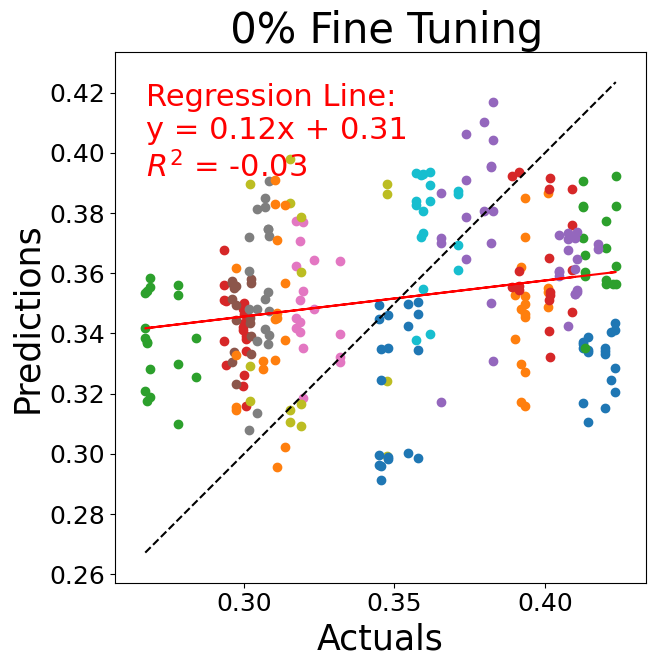

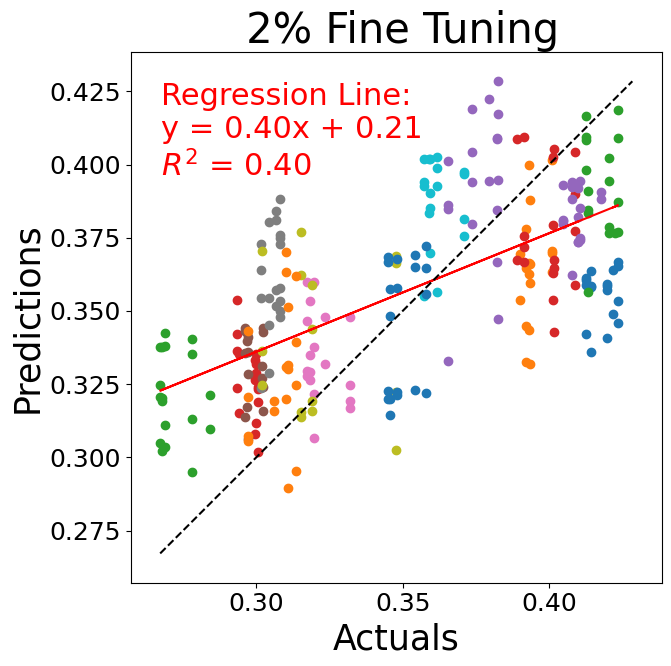

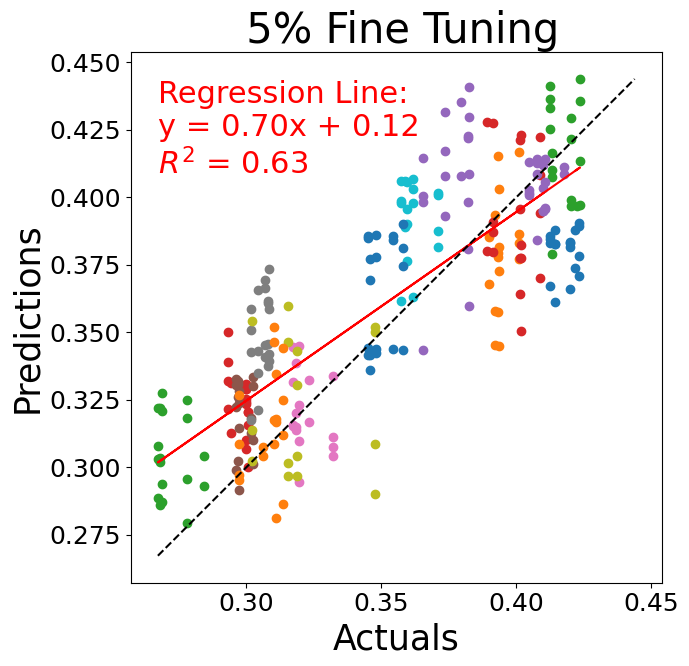

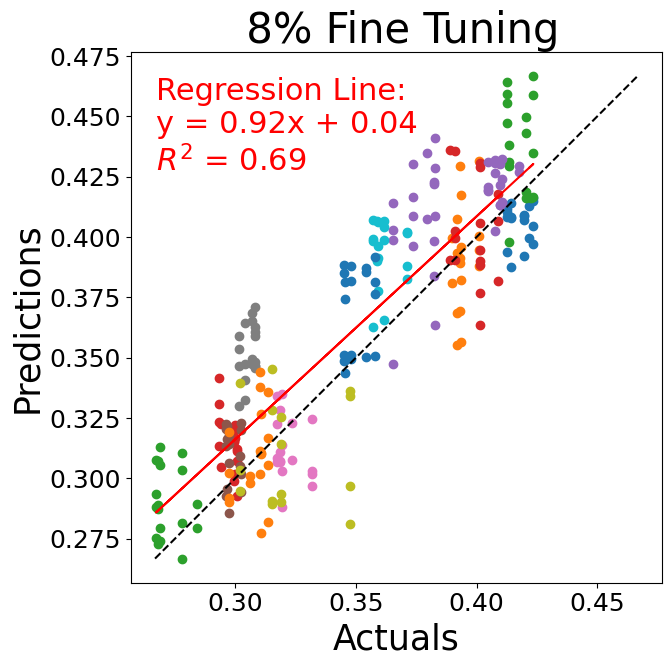

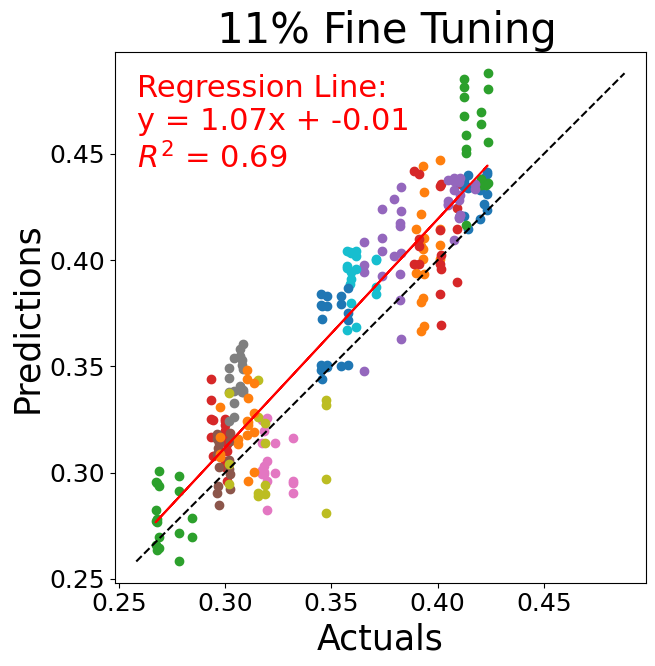

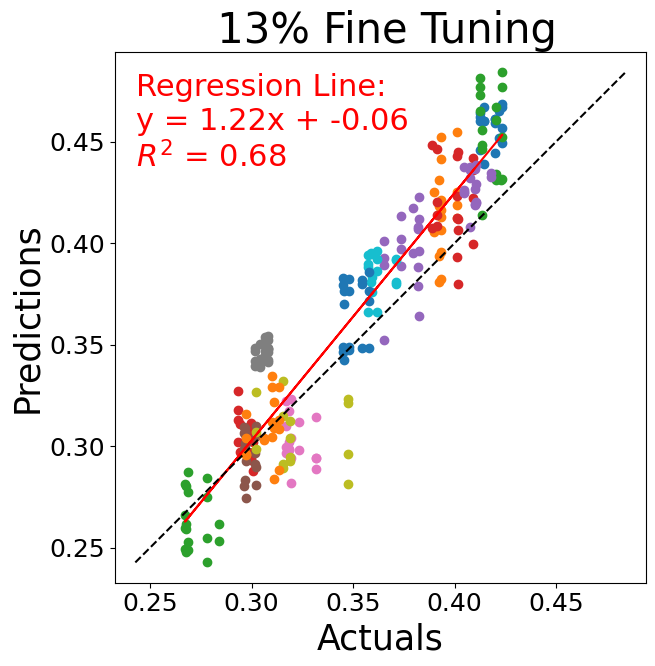

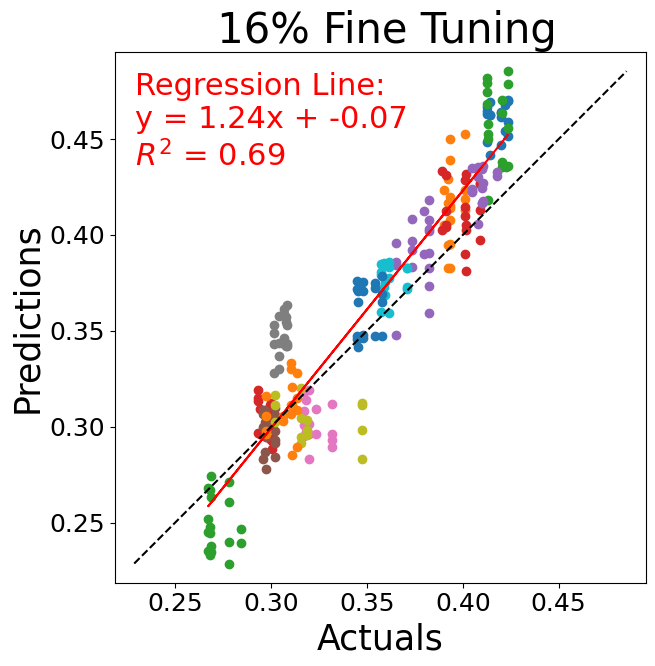

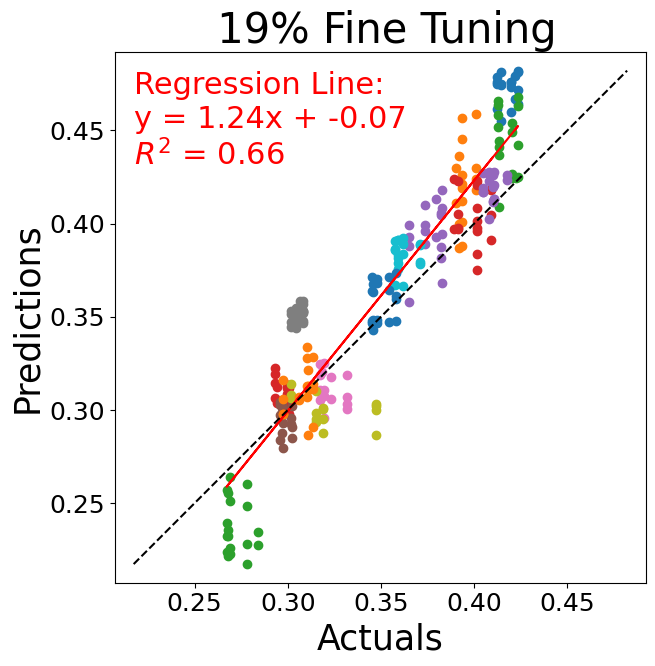

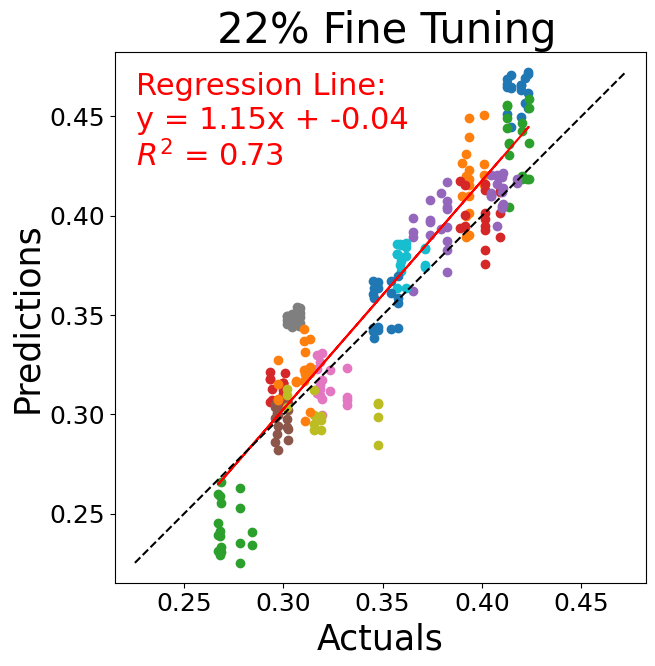

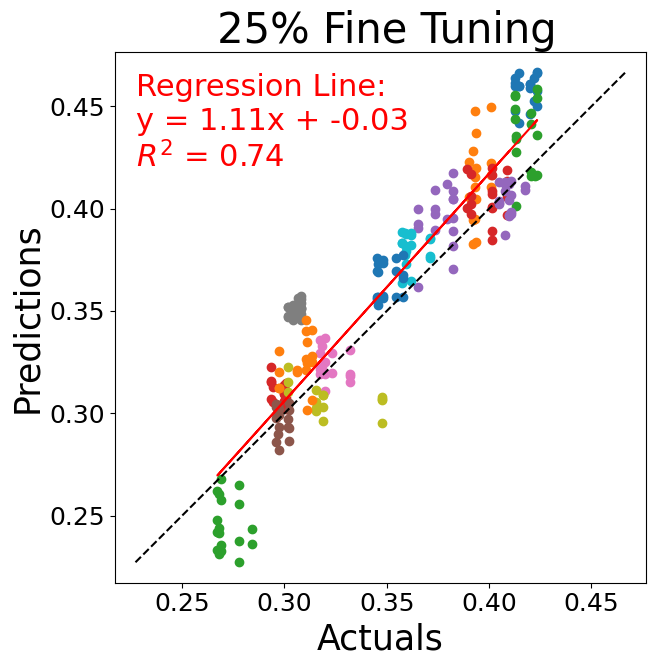

In [36]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(all_results):
    plt.rcParams.update({'font.size': 18})  # Increase the base font size
    for fraction_fine_tune, results in all_results.items():
        plt.figure(figsize=(10, 7))
        all_preds = []  # Collect all predictions across participants
        all_actuals = []  # Collect all actuals across participants
        
        for result in results:
            participants = set(result['participants'])
            for participant in participants:
                idx = [i for i, p in enumerate(result['participants']) if p == participant]
                preds = [result['predictions'][i] for i in idx]
                actuals = [result['actuals'][i] for i in idx]
                plt.scatter(actuals, preds, label=f'Participant {participant}')
                
                # Append these predictions and actuals to the overall lists
                all_preds.extend(preds)
                all_actuals.extend(actuals)
        
        # Calculate the overall R^2 score for this fine-tuning fraction
        overall_r2 = r2_score(all_actuals, all_preds)

        # Fit a linear model (regression line) to the overall data
        if all_actuals and all_preds:  # Ensure there are data points to fit
            A = np.vstack([all_actuals, np.ones(len(all_actuals))]).T
            m, c = np.linalg.lstsq(A, all_preds, rcond=None)[0]
            
            # Plot the regression line
            plt.plot(all_actuals, m*np.array(all_actuals) + c, 'r', label=f'Regression Line: y = {m:.2f}x + {c:.2f}')
            
            plot_min = min(min(all_actuals), min(all_preds))
            plot_max = max(max(all_actuals), max(all_preds))
            
            text_x = plot_min + (plot_max - plot_min) * 0.00125  # 5% from the left
            text_y = plot_max - (plot_max - plot_min) * 0.00125   # 5% from the top

            plt.text(text_x, text_y, f'Regression Line:\ny = {m:.2f}x + {c:.2f}\n$R^2$ = {overall_r2:.2f}', 
                    fontsize=22, color='red', va='top')

        all_values = all_actuals + all_preds
        value_min = min(all_values)
        value_max = max(all_values)
        additional_offset = 0.01
        plt.xlim(value_min-additional_offset, value_max+additional_offset)
        plt.ylim(value_min-additional_offset, value_max+additional_offset)
        plt.plot([value_min, value_max], [value_min, value_max], 'k--')  # Add a y=x reference line
        
        plt.title(f' {int(fraction_fine_tune*25)}% Fine Tuning' , fontsize=30) # (R^2: {overall_r2:.2f})
        plt.xlabel('Actuals', fontsize=25)
        plt.ylabel('Predictions', fontsize=25)
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.tight_layout()
        plt.gca().set_aspect('equal', adjustable='box')  # Ensure that aspect ratio is 1
        plt.show()

plot_predictions(all_results)

Plot R2 vs % data included

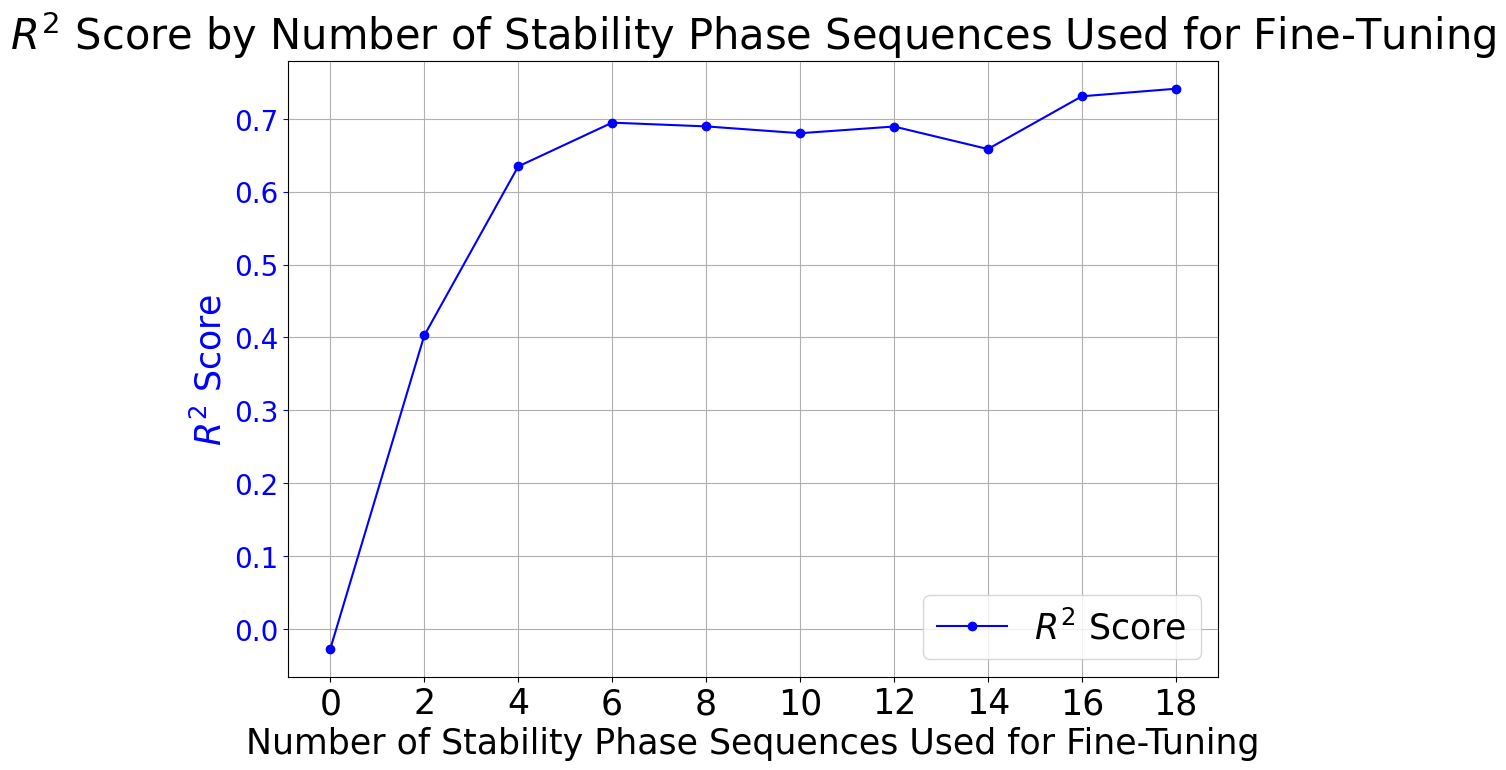

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_r2_by_number_of_captures(all_results, total_captures=18):
    # Prepare lists to hold the number of captures and corresponding R^2 scores
    num_captures = []
    r2_scores = []

    for fraction_fine_tune, results in all_results.items():
        all_preds = []
        all_actuals = []
        for result in results:
            all_preds.extend(result['predictions'])
            all_actuals.extend(result['actuals'])

        # Calculate the overall R^2 score for this fine-tuning fraction
        overall_r2 = r2_score(all_actuals, all_preds)
        
        # Append the number of captures (calculated from fraction_fine_tune) and the calculated R^2 score
        num_captures.append(fraction_fine_tune * total_captures)
        r2_scores.append(overall_r2)

    # Plot the R^2 scores by the number of captures used for fine-tuning
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(num_captures, r2_scores, marker='o', linestyle='-', color='b', label='$R^2$ Score')
    ax1.set_xlabel('Number of Stability Phase Sequences Used for Fine-Tuning', fontsize=25)
    ax1.set_ylabel('$R^2$ Score', color='b', fontsize=25)
    ax1.tick_params('y', colors='b')
    plt.xticks(range(0, total_captures+1, 2), fontsize=25)
    plt.yticks(fontsize=20)
    plt.title('$R^2$ Score by Number of Stability Phase Sequences Used for Fine-Tuning', fontsize=30)
    plt.legend(loc='lower right', fontsize=25)
    plt.grid(True)

    # # Create a second x-axis
    # ax2 = ax1.twiny()
    # ax2.set_xticks(ax1.get_xticks())  # Copy x-ticks from ax1
    # ax2.set_xbound(ax1.get_xbound())  # Copy the x-axis limits
    # ax2.set_xticklabels([f"{x/total_captures*25:.0f}%" for x in ax1.get_xticks()], fontsize=10)  # Set new labels
    # ax2.set_xlabel('Percentage of Total Captures Used for Fine-Tuning', fontsize=20)

    plt.show()

# Assuming all_results is defined and filled as per your existing structure
plot_r2_by_number_of_captures(all_results)


100% Testing no Fine-tuning

Evaluating model_LOO_24.pth with 24 as the test set
The shape of the 24_MNTRL_RR_V1, tx 1 is: (100, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 1 is: (100, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 1 is: (100, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 1 is: (100, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 2 is: (101, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 3 is: (109, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 3 is: (109, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 3 is: (109, 23, 13)
The shape of the 24_MNTRL_RR_V1, tx 3 is: (109, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 1 is: (96, 23, 13)
The shape of the 24_MNTRL_RR_V2, tx 2 is: (92, 23, 13)
T

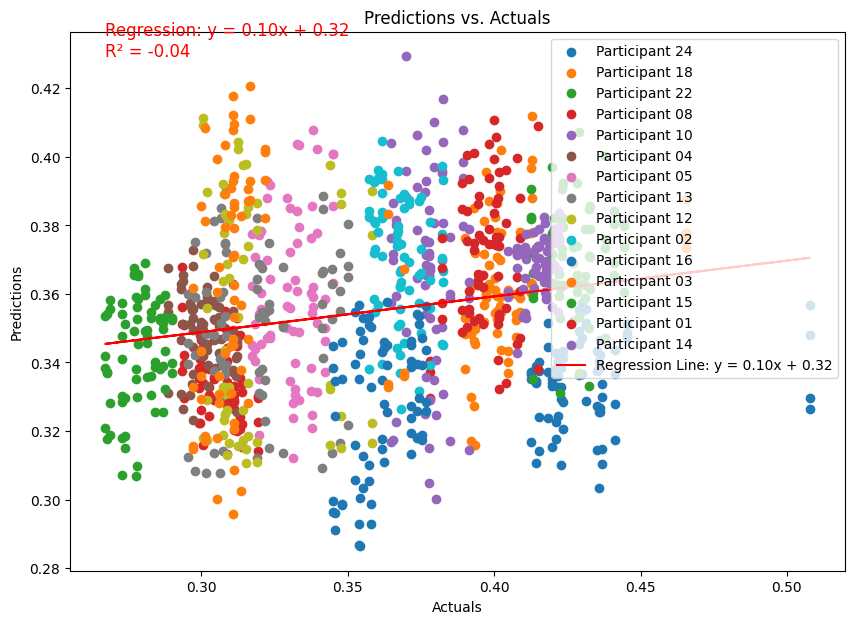

In [17]:
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define the setup_loaders function
def setup_test_loaders(root_dir, event_csv, folders):
    datasets = {x: StableRdmDataset(root_dir, event_csv, folders[x], label_type="avg_speed") for x in ['test']}
    loaders = {x: DataLoader(datasets[x], batch_size=2, shuffle=False, collate_fn=StableRdmDataset.collate_fn) for x in datasets}
    return loaders

def load_model(model_path, device):
    """Load a pre-trained model."""
    model = RdmCNNLSTMModel(num_channels=1, hidden_dim=128, lstm_layers=2, bidirectional=False)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, actuals, participants = [], [], []
    with torch.no_grad():
        for inputs, labels, _, metadata in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).cpu().numpy())
            actuals.extend(labels.view(-1).cpu().numpy())
            participants.extend([meta['participant_id'] for meta in metadata])
    
    r2 = r2_score(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    return r2, mse, predictions, actuals, participants

def plot_predictions(all_results):
    plt.figure(figsize=(10, 7))
    all_preds = []  # Collect all predictions across participants and models
    all_actuals = []  # Collect all actuals across participants and models
    
    for result in all_results:
        participants = set(result['participants'])
        for participant in participants:
            idx = [i for i, p in enumerate(result['participants']) if p == participant]
            preds = [result['predictions'][i] for i in idx]
            actuals = [result['actuals'][i] for i in idx]
            plt.scatter(actuals, preds, label=f'Participant {participant}')
            # Append these predictions and actuals to the overall lists
            all_preds.extend(preds)
            all_actuals.extend(actuals)
    
    # Calculate and plot regression line across all models and participants
    if all_actuals and all_preds:  # Ensure there are data points to fit
        A = np.vstack([all_actuals, np.ones(len(all_actuals))]).T
        m, c = np.linalg.lstsq(A, all_preds, rcond=None)[0]
        plt.plot(all_actuals, m*np.array(all_actuals) + c, 'r', label=f'Regression Line: y = {m:.2f}x + {c:.2f}')
        # Display the equation and R² score on the plot
        overall_r2 = r2_score(all_actuals, all_preds)
        plt.text(min(all_actuals), max(all_preds), f'Regression: y = {m:.2f}x + {c:.2f}\nR² = {overall_r2:.2f}', fontsize=12, color='red')

    plt.title('Predictions vs. Actuals')
    plt.xlabel('Actuals')
    plt.ylabel('Predictions')
    plt.legend()
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models_dir = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/LOO_CV_models"
    root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch'
    event_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"
    
    # Automatically load model paths
    model_paths = [os.path.join(models_dir, f) for f in os.listdir(models_dir) if f.startswith('model_LOO_') and f.endswith('.pth')]
    
    # Get all folders and shuffle them randomly for reproducibility if needed
    all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    random.seed(42)
    random.shuffle(all_folders)

    all_results = []
    
    for model_path in model_paths:
        model_name = os.path.basename(model_path)
        test_folder = model_name.replace('model_LOO_', '').replace('.pth', '')
        print(f"Evaluating {model_name} with {test_folder} as the test set")

        if test_folder not in all_folders:
            print(f"Test folder {test_folder} not found in the dataset. Skipping...")
            continue

        folders = {'test': [test_folder]}
        loaders = setup_test_loaders(root_dir, event_csv, folders)
        test_loader = loaders['test']
        
        model = load_model(model_path, device)  # Load model once here
        
        print(f"Evaluating model: {model_path}")
        r2, mse, preds, actuals, participants = evaluate_model(model, test_loader, device)
        all_results.append({
            'model_path': model_path,
            'r2_score': r2,
            'mse': mse,
            'predictions': preds,
            'actuals': actuals,
            'participants': participants
        })

    return all_results

if __name__ == "__main__":
    all_results = main()
    plot_predictions(all_results)

